### Trabalho 2 - Robótica Movel - MO651
#### __Professor(a):__ _Esther Luna Columbini_ <br>
__Alunos:__ <br>
_Tito Barbosa Rezende_              __RA:__ 025327<br>
_João Paulo Franco Assumpção_                        __RA:__ 229322<br>
_Elcio Pereira de Souza Junior_     __RA:__ 262952

### Pré-requisitos

Instalação das bibliotecas necessárias.

In [ ]:
%pip install matplotlib
%pip install numpy
%pip install opencv-python

In [3]:
import sys, time
sys.path.insert(0, '../src')
from IPython.display import clear_output
from robot import Robot
import utils
import matplotlib.pyplot as plt
import numpy as np
import vrep
import math
import random
import collections
from datetime import datetime
import skfuzzy as fuzz
from skfuzzy import control as ctrl

## 1 - Classes e funções do trabalho 1

### 1.1 Sensor Laser

In [14]:
class Laser_sensor:
    def __init__(self,robot):
        self.robot = robot

    def update_robot_frame_reading(self):
        laser_flatten_readings = np.array(self.robot.read_laser())
        laser_readings = laser_flatten_readings.reshape((len(laser_flatten_readings)//3, 3))
        self.laser_x = laser_readings[:,0]
        self.laser_y = laser_readings[:,1]

def plot_laser_robot_frame():
    fig, ax = plt.subplots()
    #posição dos feixes laser
    ax.scatter(laser_sensor.laser_x, laser_sensor.laser_y, 3, c='g', marker='o')
    #posição do centro do robo
    ax.scatter(0, 0, 40, c='b', marker='o')
    plt.show()

### 1.2 Sensor Ultrassônico

In [15]:
class Us_sensor:
    def __init__(self,robot):
        orientation_angles = np.array([90,50,30,10,-10,-30,-50,-90,-90,-130,-150,-170,170,150,130,90])
        orientation_rad = np.radians(orientation_angles)
        self.data = {
        "prefix" : "Pioneer_p3dx_ultrasonicSensor",
        "ids" : np.arange(1,17,1), "handles" : np.zeros(16, dtype=int), 
        "positions" :  np.zeros((16,3),dtype=float),
        "angles_deg": orientation_angles,
        "angles_rad": orientation_rad,
        "raw_reading": np.zeros(16),
        "robot_frame_reading": np.zeros((16,2),dtype=float)
        }
        self.robot = robot
        
        for i,sensor_i in enumerate(self.data['ids']):
            ret,handle = vrep.simxGetObjectHandle(self.robot.clientID, self.data['prefix'] + str(sensor_i), vrep.simx_opmode_oneshot_wait)
            self.data['handles'][i] = handle
            ret, pos = vrep.simxGetObjectPosition(self.robot.clientID, handle, self.robot.robot_handle, vrep.simx_opmode_oneshot_wait)
            self.data['positions'][i,:] = pos
        
    def get_left_distance(self):
        self.update_raw_reading()
        return np.min(np.array(self.data["raw_reading"][0]))
    
    def get_front_distance(self):
        self.update_raw_reading()
        return np.min(np.array([self.data["raw_reading"][3:5]]))        
    
    def get_right_distance(self):
        self.update_raw_reading()
        return np.min(np.array([self.data["raw_reading"][7:9]]))
    
    def update_raw_reading(self):
        self.data["raw_reading"] = np.array(self.robot.read_ultrassonic_sensors())
    
    def update_robot_frame_reading(self):
        self.update_raw_reading()
        for i, proximity in enumerate(us_sensors.data["raw_reading"]):
            if proximity == 5 or proximity < 0.1:
                self.data["robot_frame_reading"][i] = np.zeros(2)
            else:
                self.data["robot_frame_reading"][i] = self.proximity_robot_frame(i+1,proximity).flatten()
                
    #Calcula o ponto no frame do robo, referente a leitura de cada sensor de proximidade
    def proximity_robot_frame(self,sensorId, proximity):
        index = sensorId -1
        angulars = self.data["angles_rad"][index]
        #Matriz de rotação
        rot_matrix = np.array([[math.cos(angulars),-math.sin(angulars)],[math.sin(angulars),math.cos(angulars)]])
        #Rotacionando a leitura
        distXY = np.dot(rot_matrix , np.array([[proximity],[0]]))
        #Matriz de translação
        posicao_sensor_x = self.data["positions"][index][0]
        posicao_sensor_y = self.data["positions"][index][1]
        transXY=np.array([[distXY[0][0]+posicao_sensor_x],[distXY[1][0]+posicao_sensor_y]])
        return transXY

Definimos uma função _toGlobal_ (para termos um melhor reuso de código), basicamente a função transforma um ponto qualquer _(x,y)_ que esteja na referência do robô e o leva para a referência global.

In [16]:
def toGlobal(robot_x, robot_y,robot_ang, Point_xr, Point_yr):
    T_trans = np.array([[1,0,robot_x],[0,1,robot_y],[0,0,1]])
    T_rot = np.array([[math.cos(robot_ang),-math.sin(robot_ang),0],[math.sin(robot_ang),math.cos(robot_ang),0],[0,0,1]])
    T = np.dot(T_trans,T_rot)
    res = np.dot(T, np.array([Point_xr,Point_yr,1]))
    return res[0],res[1]
def fromGlobal(robot_x, robot_y,robot_ang, Point_xr, Point_yr):
    T_trans = np.array([[1,0,-robot_x],[0,1,-robot_y],[0,0,1]])
    T_rot = np.array([[math.cos(robot_ang),math.sin(robot_ang),0],[-math.sin(robot_ang),math.cos(robot_ang),0],[0,0,1]])
    T = np.dot(T_rot,T_trans)
    res = np.dot(T, np.array([Point_xr,Point_yr,1]))
    ang = np.arctan2(res[1],res[0])
    return res[0],res[1], ang

### 1.3 Modelo Cinemático

In [17]:
class Kinematic_model:
    def __init__(self,robot):
        self.robot = robot
        #Handles dos motores
        ret1, self.motorLeft = vrep.simxGetObjectHandle(self.robot.clientID, "Pioneer_p3dx_leftMotor", vrep.simx_opmode_oneshot_wait)
        ret2, self.motorRight = vrep.simxGetObjectHandle(self.robot.clientID, "Pioneer_p3dx_rightMotor", vrep.simx_opmode_oneshot_wait)
        #Calcula distancia de eixo
        res, left_handle = vrep.simxGetObjectHandle(robot.clientID, "Pioneer_p3dx_leftMotor", vrep.simx_opmode_oneshot_wait)
        ret, lpos = vrep.simxGetObjectPosition(robot.clientID, left_handle, robot.robot_handle, vrep.simx_opmode_oneshot_wait)
        res, right_handle = vrep.simxGetObjectHandle(robot.clientID, "Pioneer_p3dx_rightMotor", vrep.simx_opmode_oneshot_wait)
        ret, rpos = vrep.simxGetObjectPosition(robot.clientID, right_handle, robot.robot_handle, vrep.simx_opmode_oneshot_wait)
        # eixo
        self.l = (abs(lpos[1]) + abs(rpos[1]))/2
        #Ao ser criado, coleta a referencia de zero do robo
        pos = self.robot.get_current_position()
        self.initial_pos_x = pos[0]
        self.initial_pos_y = pos[1]
        orientation = self.robot.get_current_orientation()
        self.initial_orientation = orientation[2]
        #Alem de mantermos a pose inicial, manteremos a pose atualizada do robo
        self.enc_global_x = self.initial_pos_x
        self.enc_global_y = self.initial_pos_y
        self.enc_Theta = self.initial_orientation
        self.time_global_x = self.initial_pos_x
        self.time_global_y = self.initial_pos_y
        self.time_Theta = self.initial_orientation
    
        #Lista de pontos para o caminho do robo
        self.enc_path = []
        self.time_path = []
        self.true_path = []
        self.update_paths()    
        #inicializando a posição dos encoders
        self.jL = self.current_encoder_left()
        self.jR = self.current_encoder_right()
        #intervalo entre cada calculo
        self.compute_interval = 0.1
        self.previous_timestamp = 0
        
    def update_paths(self):
        self.enc_path.append([self.enc_global_x, self.enc_global_y, self.enc_Theta])
        self.time_path.append([self.time_global_x, self.time_global_y, self.time_Theta])
        orientation = self.robot.get_current_orientation()
        true_theta = orientation[2]
        current_position = self.true_global_position()
        self.true_path.append([current_position[0], current_position[1], true_theta])
    
    def true_global_position(self):
        pos = self.robot.get_current_position()
        return pos[0],pos[1]
    
    def enc_global_position(self):
        return self.enc_global_x, self.enc_global_y, self.enc_Theta
    
    def time_global_position(self):
        return self.time_global_x, self.time_global_y, self.time_Theta
    
    ##Esta seção esta relacionada ao calculo da posição levando em consideração os encoders
    def current_encoder_left(self):
        ret,jL = vrep.simxGetJointPosition(self.robot.clientID,self.motorLeft,vrep.simx_opmode_oneshot_wait)
        return jL
    
    def current_encoder_right(self):
        ret, jR = vrep.simxGetJointPosition(self.robot.clientID,self.motorRight,vrep.simx_opmode_oneshot_wait)
        return jR    
    
    #Phi speed of rotation of wheels
    def Xr(self, Phi_right, Phi_left):
        r = self.robot.WHEEL_RADIUS
        Xr = (r*Phi_left/2) + (r*Phi_right/2)
        return Xr
    
    def Theta_r(self, Phi_right, Phi_left):
        r = self.robot.WHEEL_RADIUS
        Tr = r*Phi_right/(2*self.l) - r*Phi_left/(2*self.l) 
        return Tr
        
    def speed_model(self,Phi_right,Phi_left):
        #Se formos considerar que o eixo das rodas do robo está deslocado do eixo x
        #return np.array([self.Xr(Phi_right,Phi_left),self.Theta_r(Phi_right,Phi_left)*self.l2,self.Theta_r(Phi_right,Phi_left)])
        return np.array([self.Xr(Phi_right,Phi_left),0,self.Theta_r(Phi_right,Phi_left)])
        
    def inverse_rotation_matrix(self, ang):
        Trot = np.array([[math.cos(ang), -math.sin(ang), 0], [math.sin(ang), math.cos(ang), 0], [0,0,1]])
        return Trot
    
    def locomotion_global(self, ang, Phi_right, Phi_left):
        return np.dot(self.inverse_rotation_matrix(ang),self.speed_model(Phi_right,Phi_left))
    
    def compute_with_encoder(self):
        dxR = self.current_encoder_right() - self.jR
        dxL = self.current_encoder_left() - self.jL
        if (dxL>=0):
            dxL=math.fmod(dxL+math.pi,2*math.pi)-math.pi
        else:
            dxL=math.fmod(dxL-math.pi,2*math.pi)+math.pi
        if (dxR>=0):
            dxR=math.fmod(dxR+math.pi,2*math.pi)-math.pi
        else:
            dxR=math.fmod(dxR-math.pi,2*math.pi)+math.pi
        qsi = self.locomotion_global(self.enc_Theta,dxR, dxL)
        #Atualiza a posição global
        self.enc_global_x = self.enc_global_x + qsi[0]
        self.enc_global_y = self.enc_global_y + qsi[1]
        self.enc_Theta = self.enc_Theta + qsi[2]
        #Atualiza a posição dos encoders
        self.jR = self.current_encoder_right()
        self.jL = self.current_encoder_left()
    ##Fim da seção relacionada ao calculo da posição levando em consideração os encoders        
    
    def compute_with_time(self, Phi_right, Phi_left):
        #Calculo do delta S
        r = self.robot.WHEEL_RADIUS
        Vr = r*Phi_right
        Vl = r*Phi_left
        current_timestamp = datetime.timestamp(datetime.now())
        Delta_t = current_timestamp - self.previous_timestamp
        #atualiza timestamp imediatamente

        self.previous_timestamp = current_timestamp
        
        Delta_s = (Vr + Vl)*Delta_t/2  
        Delta_Theta = (Vr - Vl)*Delta_t/(2*self.l)
    
        self.time_global_x = self.time_global_x + Delta_s*math.cos(self.time_Theta + Delta_Theta/2)
        self.time_global_y = self.time_global_y + Delta_s*math.sin(self.time_Theta + Delta_Theta/2)
        self.time_Theta = self.time_Theta + Delta_Theta
    
    def move(self,Phi_right, Phi_left,seconds): #velocidade em rad/s
        #Vamos fixar um tempo de 500ms para computar as distâncias
        for step in range(int(seconds/self.compute_interval)):
            #self.compute()
            self.robot.set_right_velocity(Phi_right)
            self.robot.set_left_velocity(Phi_left)
            time.sleep(self.compute_interval)
            self.compute_with_encoder()
            self.compute_with_time(Phi_right, Phi_left)
            self.update_paths()
        self.robot.stop()
        self.timestamp = 0
        
    def turnGlobal(self, input_ang):
        orientation = self.robot.get_current_orientation()[2]
        ang = input_ang
        if (orientation < 0):
            orientation = orientation + 2*math.pi
        if (ang < 0):
            ang = ang + 2*math.pi
            
        print("Initial orientation ", orientation)
        print("Ang ", ang)
        vel = 0.2
        
        if ((ang - orientation) > math.pi) or (0 > (ang - orientation) > -math.pi):
            vel = - vel
        
        self.robot.set_right_velocity(vel)
        self.robot.set_left_velocity(-vel)
        tolerance = math.pi/90
        while ((ang - orientation) > tolerance) or ((ang - orientation) < -tolerance):
            time.sleep(0.05)
            orientation = self.robot.get_current_orientation()[2]
            if (orientation < 0):
                orientation = orientation + 2*math.pi
            sys.stdout.write("\r" + "Diff " + str((ang - orientation)) + " orientation " + str(orientation))
            sys.stdout.flush()
        self.robot.stop()
        print("curr orientation ", orientation)        
        
    def ICR_left(self, Phi_left, R, seconds):
        Phi_right = Phi_left*(R + self.l)/(R - self.l)
        print("ICR_left Phi_r {} Phi_l {}".format(Phi_right, Phi_left))
        self.move(Phi_right, Phi_left, seconds)
    
    def ICR_right(self, Phi_right, R, seconds):
        Phi_left = Phi_right*(R + self.l)/(R - self.l)
        print("ICR_right Phi_r {} Phi_l {}".format(Phi_right, Phi_left))
        self.move(Phi_right, Phi_left, seconds)
  
    def plot_paths(self):
        enc_path = np.array(self.enc_path)
        time_path = np.array(self.time_path)
        true_path = np.array(self.true_path)
        
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
        ax[0].scatter(enc_path[:,0], enc_path[:,1], 5, c='b', marker='o')
        #ax[1].scatter(time_path[:,0], time_path[:,1], 5, c='g', marker='o')
        ax[1].scatter(true_path[:,0], true_path[:,1], 5, c='r', marker='o')

### 1.4 Nuvem de pontos

Para a nuvem de pontos, nós coletamos os dados fornecidos pelo laser (conjunto de pontos) que estão baseados no sistema de referência do robô, após aplicamos a transformação destes pontos para o sistema de referência global. Dados os pontos no sistema global nós realizamos a plotagem dos mesmos.

In [18]:
class PointCloud():
    def __init__(self, robot, us_sensors, laser_sensor):
        self.robot = robot
        self.us_sensors = us_sensors
        self.laser_sensor = laser_sensor
        
        self.ultrassonic_points = []
        self.laser_points = []
        self.robot_points = []
    
    def update(self):
        #Insere posição atual do robo
        robot_x = self.robot.get_current_position()[0]
        robot_y = self.robot.get_current_position()[1]
        robot_ang = self.robot.get_current_orientation()[2]
        
        self.robot_points.append([robot_x,robot_y])

        #Atualiza a leitura do laser e insere na nuvem de pontos
        self.laser_sensor.update_robot_frame_reading()
        for pointx, pointy in zip(self.laser_sensor.laser_x, self.laser_sensor.laser_y):
            x,y = toGlobal(robot_x, robot_y,robot_ang, pointx, pointy)
            self.laser_points.append([x,y])

        #Atualiza a leitura do ultrassonico e insere na nuvem de pontos
        self.us_sensors.update_robot_frame_reading()
        for pointx, pointy in zip(self.us_sensors.data['robot_frame_reading'][:,0], self.us_sensors.data['robot_frame_reading'][:,1]):
            x,y = toGlobal(robot_x, robot_y,robot_ang, pointx, pointy)
            self.ultrassonic_points.append([x,y])
    
    def plot_point_cloud(self):
        #Convertendo a nuvem de pontos em um array
        ultrassonic_point_array = np.array(self.ultrassonic_points)
        laser_point_array = np.array(self.laser_points)
        robot_path = np.array(self.robot_points)

        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
        #posição do centro do robo
        ax[0].scatter(robot_path[:,0], robot_path[:,1], 40, c='b', marker='o')
        pass_count = 0
        for x, y in zip(robot_path[:,0], robot_path[:,1]):
            ax[0].text(x, y, str(pass_count), color="black", fontsize=12)
            pass_count += 1
        #posição dos pontos lidos pelo sensor ultrassonico
        ax[0].scatter(ultrassonic_point_array[:,0],ultrassonic_point_array[:,1], 10, c='magenta', marker='.')

        #posição do centro do robo
        ax[1].scatter(robot_path[:,0], robot_path[:,1], 40, c='b', marker='o')
        pass_count = 0
        for x, y in zip(robot_path[:,0], robot_path[:,1]):
            ax[1].text(x, y, str(pass_count), color="black", fontsize=12)
            pass_count += 1
        #posição dos pontos lidos pelo sensor laser
        ax[1].scatter(laser_point_array[:,0],laser_point_array[:,1], 10, c='r', marker='.')

        plt.show()

## 2 - Code of Project 2

The general objective of this work is to build, on the V-REP robotic simulator, a set of behaviors to control a Pioneer P3-DX robot.
3 Behaviours were developed:<br>
    <blockquote>2.1 AvoidObstacle<br>
    2.2 WallFollow<br>
    2.3 GoToGoal</blockquote>

### 2.1 - AvoidObstacle

This behaviour was implemented using Fuzzy logic. In other to correctlly demonstrate the behavior, a simple wandering algorith is simulated bellow

Start robot and test the 8 frontal sonar sensors.

In [10]:
robot = Robot()
distances = robot.read_ultrassonic_sensors()
frontal = distances[:8]
print(frontal)

Connected to remoteApi server.
 Pioneer_p3dx_ultrasonicSensor1 connected.
 Pioneer_p3dx_ultrasonicSensor2 connected.
 Pioneer_p3dx_ultrasonicSensor3 connected.
 Pioneer_p3dx_ultrasonicSensor4 connected.
 Pioneer_p3dx_ultrasonicSensor5 connected.
 Pioneer_p3dx_ultrasonicSensor6 connected.
 Pioneer_p3dx_ultrasonicSensor7 connected.
 Pioneer_p3dx_ultrasonicSensor8 connected.
 Pioneer_p3dx_ultrasonicSensor9 connected.
 Pioneer_p3dx_ultrasonicSensor10 connected.
 Pioneer_p3dx_ultrasonicSensor11 connected.
 Pioneer_p3dx_ultrasonicSensor12 connected.
 Pioneer_p3dx_ultrasonicSensor13 connected.
 Pioneer_p3dx_ultrasonicSensor14 connected.
 Pioneer_p3dx_ultrasonicSensor15 connected.
 Pioneer_p3dx_ultrasonicSensor16 connected.
 Vision sensor connected.
 Laser connected.
 Left motor connected.
 Right motor connected.
 Robot connected.
[0.311331570148468, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]


First, bellow Fuzzyfication function was implemented, receiving as its input the reading of the sonar sensors. The eight frontal sonar sensors was classified into 3 groups: left sensors (__x_l:__ 1 to 3 sensors); forward (__x_f:__ 3 to 6 sensors) and; right (__x_r:__ 6 to 8 sensors). For fuzzification we adopted the minimal value each one.

We choose 0.1m as __near__ and values between 0.1 and 0.4m as __almost near__. Far value was considered irrelevant in results.

The function print a graphic result if you set the __\_print__ value to __1__.

Left sensors fuzzyfication: 1.0


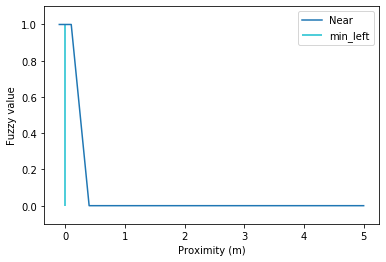

In [11]:
def sensor_fuzzyfication(frontal_sensors,_print=0) :
    x_v = np.arange(-0.1, 5.1, 0.1)
    t_close = [-0.1, -0.1, 0.1, 0.4]
    mfx_close = fuzz.trapmf(x_v, t_close)
    #t_far = [0.3, .55, 5, 5]                /// Results are irrelevant
    #mfx_far = fuzz.trapmf(x_v, t_far)       /// Results are irrelevant
    x_l = np.array([round(min(frontal_sensors[:2]))])    # Left sensors
    x_f = np.array([min(frontal_sensors[3:5])])          # Forward Sensors
    x_r = np.array([round(min(frontal_sensors[6:8]),1)]) # Right sensors
    y_l = np.array([-1]) # Null value
    y_f = np.array([-1]) # Null value
    y_r = np.array([-1]) # Null value
    if(x_l[0] < 1) :
        y_l = fuzz.trapmf(x_l, t_close) # Return fuzzy value for left sensors
    if(x_f[0] < 1) :
        y_f = fuzz.trapmf(x_f, t_close) # Return fuzzy value for forward sensors
    if(x_r[0] < 1) :
        y_r = fuzz.trapmf(x_r, t_close) # Return fuzzy value for right sensors
    
    # Just for print mode
    if (_print > 0) : 
        plt.plot(x_v, mfx_close,label="Near")
        colors = ['tab:black','tab:cyan','tab:purple','tab:green','tab:red','tab:brown','tab:olive','tab:gray','tab:pink']
        if(x_l[0] < 1) : plt.vlines(x_l, 0, y_l, label="min_left",color=colors[1]); print("Left sensors fuzzyfication: "+str(y_l[0]))
        if(x_f[0] < 1) : plt.vlines(x_f, 0, y_f, label="min_forward",color=colors[2]); print("Forward sensors fuzzyfication: "+str(y_f[0]))
        if(x_r[0] < 1) : plt.vlines(x_r[0], 0, y_r, label="min_right",color=colors[3]); print("Right sensors fuzzyfication: "+str(y_r[0]))
        plt.ylabel('Fuzzy value')
        plt.xlabel('Proximity (m)')
        plt.ylim(-0.1, 1.1)
        plt.legend(loc=1)
        plt.draw()
        plt.pause(0.05)
    
    # Return useful value: used X range; Y result values.
    return x_v, y_l, y_f, y_r

fuzzy = sensor_fuzzyfication(frontal,1)

Then, the object avoidance will be given by the defuzzyfication function bellow, acting in oposition to the proximitiy sensor. The function starts an initial verification if the frontal sensors minimal value is grater than 0.4m (our almost near value). In this case it returns the angular velocity equal 2 to both wheels. Else, it goes to defuzzification angular velocity.

Distance Left: 0.311331570148468
Distance Forward: 5.0
Distance Right: 5.0
Collision: -58.0°


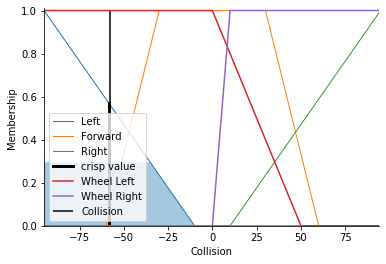

Wheel left angular velocity: 2.0
Wheel right angular velocity: -2.0


(2.0, -2.0)

In [24]:
def avoidByDefuzzyfication(frontal_sensors,fuzzy_results, _print=0) :
    if (min(frontal_sensors) > 0.4) : # in case all frontal sensor is grater than 0.4m
        velL = 2
        velR = 2
        return velL, velR           # Stop function and return equal values. 
                                    # This condition avoid a defuzzy error obtaining a null crisp value
    y_v = np.arange(-95, 95, 1)
    x_v = fuzzy_results[0]

    mfy_left = fuzz.trimf(y_v, [-95, -95,-10])       # Values to get  a left collision probabillity
    mfy_forward = fuzz.trapmf(y_v, [-60,-30, 30,60]) # Values to get  a forward collision probabillity
    mfy_right = fuzz.trimf(y_v, [10,95,95])          # Values to get  a right collision probabillity

    proximityL = ctrl.Antecedent(x_v, 'proximityL')
    proximityR = ctrl.Antecedent(x_v, 'proximityR')
    proximityF = ctrl.Antecedent(x_v, 'proximityF')
    prob = ctrl.Consequent(y_v, 'Collision')         # Collision probabillity

    proximity = fuzz.trapmf(x_v,[-0.1, -0.1, 0.1, 0.4])
    proximityL['near'] = proximity
    proximityR['near'] = proximity
    proximityF['near'] = proximity
    prob['Left'] = mfy_left
    prob['Forward'] = mfy_forward
    prob['Right'] = mfy_right


    # This method define 3 rules to get our fuzzy set
    rule1 = ctrl.Rule(proximityL['near'] , prob['Left'])
    rule2 = ctrl.Rule(proximityF['near'] , prob['Forward'])
    rule3 = ctrl.Rule(proximityR['near'], prob['Right'])

    vel_ctrl = ctrl.ControlSystem([rule1, rule2, rule3]) # Defuzzy rules for collision possibility
    vel = ctrl.ControlSystemSimulation(vel_ctrl)

    vel.input['proximityL'] = min(frontal_sensors[:3])
    vel.input['proximityR'] = min(frontal_sensors[5:8])
    vel.input['proximityF'] = min(frontal_sensors[2:6])

    if (_print > 0) :
        # Print minimal sensor distances
        print("Distance Left: "+str(min(frontal[:3])))
        print("Distance Forward: "+str(min(frontal[2:6])))
        print("Distance Right: "+str(min(frontal[5:8])))

    vel_output = 1

    if (min(frontal_sensors) <= 1):
        vel.compute()
        # Using Mamdani's method we output a fuzzy set 
        # and obtain a crisp value from centroid
        
        vel_output = round(vel.output['Collision'])   # Collision angle probabillity crisp value
        Collision = "Collision: "+str(vel_output)+"°"
    else: Collision = "No collision"
    if (_print > 0) :
        print(Collision)
        prob.view(sim=vel)
    
    x_w = np.arange(-100,100,0.1)
    wlv = [-100, -100,0,50]    # Fuzzify crisp value to obtain left wheel angular velocity
    wrv = [0,10,100,100]       # Fuzzify crisp value to obtain right wheel angular velocity
    # We use diferent trapezoidal graphics for the wheels to avoid equal speed in frontal collision possibility
    
    x = np.array([vel_output])
    y_l=fuzz.trapmf(x, wlv)    # Fuzzy value for left wheel
    y_r=fuzz.trapmf(x, wrv)    # Fuzzy value for right wheel
    if (_print > 0) :
        #Print graphics
        WheelL = fuzz.trapmf(x_w, wlv)
        WheelR = fuzz.trapmf(x_w, wrv)
        plt.plot(x_w, WheelL,label="Wheel Left")
        plt.plot(x_w, WheelR,label="Wheel Right")
        plt.vlines(x, 0, y_l, label="Collision")
        plt.vlines(x, 0, y_r)
        plt.legend()
        plt.draw()
        plt.pause(0.05)
        print("Wheel left angular velocity: "+str((y_l[0]-0.5)/0.25))
        print("Wheel right angular velocity: "+str((y_r[0]-0.5)/0.25))
    
    velL = (y_l[0]-0.5)/0.25    #Convert Fuzzy value into angular speed for left wheel
    velR = (y_r[0]-0.5)/0.25    #Convert Fuzzy value into angular speed for right wheel

    return velL, velR
avoidByDefuzzyfication(frontal,fuzzy,1)

Our mobile robot class, implementing the fuzzy controller will be given by:

In [22]:
class MobileRobotAvoid():
    def __init__(self):
        self.robot = Robot()
        self.kinematicModel = Kinematic_model(self.robot)
        self.us_sensors = Us_sensor(self.robot)
        self.laser_sensors = Laser_sensor(self.robot)
        self.compute_interval = 0.2
        
    def control(self, frontal):
        fuzzy = sensor_fuzzyfication(frontal)
        avoid = avoidByDefuzzyfication(frontal,fuzzy)    # Defuzzyfication
        return avoid[0], avoid[1]                        # Return angular speed from the sensors

    def startWander(self, seconds):
        
        for step in range(int(seconds/self.compute_interval)): # Repeat avoidance each 0.2s (self.compute_interval)
            Phi_l, Phi_r = self.control(self.robot.read_ultrassonic_sensors()[:8]) # Get angular speed from avoidance function
            self.kinematicModel.move(Phi_r, Phi_l,self.compute_interval)           # Apply angular speed to kinematic model
            
mr = MobileRobotAvoid()

Connected to remoteApi server.
 Pioneer_p3dx_ultrasonicSensor1 connected.
 Pioneer_p3dx_ultrasonicSensor2 connected.
 Pioneer_p3dx_ultrasonicSensor3 connected.
 Pioneer_p3dx_ultrasonicSensor4 connected.
 Pioneer_p3dx_ultrasonicSensor5 connected.
 Pioneer_p3dx_ultrasonicSensor6 connected.
 Pioneer_p3dx_ultrasonicSensor7 connected.
 Pioneer_p3dx_ultrasonicSensor8 connected.
 Pioneer_p3dx_ultrasonicSensor9 connected.
 Pioneer_p3dx_ultrasonicSensor10 connected.
 Pioneer_p3dx_ultrasonicSensor11 connected.
 Pioneer_p3dx_ultrasonicSensor12 connected.
 Pioneer_p3dx_ultrasonicSensor13 connected.
 Pioneer_p3dx_ultrasonicSensor14 connected.
 Pioneer_p3dx_ultrasonicSensor15 connected.
 Pioneer_p3dx_ultrasonicSensor16 connected.
 Vision sensor connected.
 Laser connected.
 Left motor connected.
 Right motor connected.
 Robot connected.


Bellow, test startWander function for 50s.

In [23]:
mr.startWander(50)

__Conclusion:__ We tested __startWander__ function for 60 minutes and the robot didn't collide or stop, avoiding each obstacle.

### 2.2 - Wall Follow

This behaviour was implemented using a PID controller. In other to demonstrate the behaviour, two classes were created.One of the PID controller itselft, and the other a Robot Class, which uses the previous work of Project 1 kinematic model and sensors.

#### 2.2.1 PID Controller

The PID gains were obtained experimentally. Both Integral and Derivative did not performed well on hour case, specially during the countour of the couch. For P gains lower than 1, the robot is too slow to correct its trajectory and ocasionally the distance of the wall becomes greather than 1 meter and the robot stops following the wall. If the P gain is too high, the controller correction is too great and the robot overshots, turning around its own axis trying to go back to the wall, which causes the left sensor to loose the wall reading.
We can perceive here that with the controller alone is very dificult to guide the robot. Thus, there is a need for a behaviour coordination strategy.

In [21]:
class PID():
    def __init__(self, P=1, I=0.0, D=0, Derivator=0, Integrator=0, Integrator_max=500, Integrator_min=-500):
        self.Kp=P
        self.Ki=I
        self.Kd=D
        self.Derivator=Derivator
        self.Integrator=Integrator
        self.Integrator_max=Integrator_max
        self.Integrator_min=Integrator_min
        self.set_point=0.0
        self.error=0.0
        self.IntegralWindow = collections.deque(maxlen=10)
        
    def update(self,current_value):
        self.error = self.set_point - current_value
        self.P_value = self.Kp * self.error
        self.D_value = self.Kd * ( self.error - self.Derivator)
        self.Derivator = self.error
        self.IntegralWindow.append(self.error)
        self.Integrator = sum(self.IntegralWindow)

        if self.Integrator > self.Integrator_max:
            self.Integrator = self.Integrator_max
        elif self.Integrator < self.Integrator_min:
            self.Integrator = self.Integrator_min

        self.I_value = self.Integrator * self.Ki

        PID = self.P_value + self.I_value + self.D_value
        #print("PID cv ",current_value ," sp ", self.set_point ," error ", self.error ," pid ", PID)
        sys.stdout.write("\r" + "PID cv " + str(current_value) + " sp " + str(self.set_point) + " error " + str(self.error) + " pid " + str(PID))
        sys.stdout.flush()
        return PID

    def setPoint(self,set_point):
        self.set_point = set_point
        self.Integrator=0
        self.Derivator=0

In [22]:
class MobileRobot():
    def __init__(self):
        self.robot = Robot()
        self.kinematicModel = Kinematic_model(self.robot)
        self.us_sensors = Us_sensor(self.robot)
        self.laser_sensors = Laser_sensor(self.robot)
        self.pidL = PID()
        self.pidL.setPoint(0.5)
        self.compute_interval = 0.5
        self.follow_wall_side = "LEFT"
        
        self.curr_state = None
        self.prev_state = None
        
    def checkCurrentState(self):
        previous_state = self.curr_state
        left = self.us_sensors.get_left_distance()
        right = self.us_sensors.get_right_distance()
        front = self.us_sensors.get_front_distance()
        #Initial state: Move Foward
        if (previous_state == None and self.prev_state == None):
            self.curr_state = 'MoveFoward'
    
        #MF->TR
        if (previous_state == 'MoveFoward' and front <= 0.5):
            self.curr_state = 'TurnRight'
            
        #TR->WF
        if (previous_state == 'TurnRight' and left <= 1):
            self.curr_state = 'WallFollow'
            
        #WF->TR
        if (previous_state == 'WallFollow' and front <= 0.5):
            self.curr_state = 'TurnRight'
            
        #WF->MoveFoward
        if (previous_state == 'WallFollow' and front == 5 and left == 5):
            self.curr_state = 'MoveFoward'
          
        #update prev
        self.prev_state = previous_state
    
    def control(self, left_distance, right_distance, front_distance ):
        left = self.us_sensors.get_left_distance()
        right = self.us_sensors.get_right_distance()
        front = self.us_sensors.get_front_distance()
        vel = 0
        turn = 0
        self.checkCurrentState()
        
        #State Machine
        ##Move foward
        if (self.curr_state == 'MoveFoward'):
            turn = 0
            vel = 3
        ##Turn Right
        elif (self.curr_state == 'TurnRight'):
            turn = 1
            vel = 0
        #Wall Follow
        elif (self.curr_state == 'WallFollow'):
            turn = self.pidL.update(left_distance)
            vel = 1
        #Turn Back
#         elif (self.curr_state == 'TurnBack'):
#             turn = -1
#             vel = 0
        self.prev_state = self.curr_state
        return vel + turn, vel - turn

    def start(self, seconds):
        for step in range(int(seconds/self.compute_interval)):
            #Phi_l, Phi_r = self.braitenberg(self.us_sensors.data["raw_reading"][:8],2)
            Phi_l, Phi_r = self.control(self.us_sensors.get_left_distance(),self.us_sensors.get_right_distance(), self.us_sensors.get_front_distance())
            self.kinematicModel.move(Phi_r, Phi_l,self.compute_interval)
            #self.kinematicModel.plot_paths()
            #self.point_cloud.update()
            #self.point_cloud.plot_point_cloud()
mr = MobileRobot()

Connected to remoteApi server.
 Pioneer_p3dx_ultrasonicSensor1 connected.
 Pioneer_p3dx_ultrasonicSensor2 connected.
 Pioneer_p3dx_ultrasonicSensor3 connected.
 Pioneer_p3dx_ultrasonicSensor4 connected.
 Pioneer_p3dx_ultrasonicSensor5 connected.
 Pioneer_p3dx_ultrasonicSensor6 connected.
 Pioneer_p3dx_ultrasonicSensor7 connected.
 Pioneer_p3dx_ultrasonicSensor8 connected.
 Pioneer_p3dx_ultrasonicSensor9 connected.
 Pioneer_p3dx_ultrasonicSensor10 connected.
 Pioneer_p3dx_ultrasonicSensor11 connected.
 Pioneer_p3dx_ultrasonicSensor12 connected.
 Pioneer_p3dx_ultrasonicSensor13 connected.
 Pioneer_p3dx_ultrasonicSensor14 connected.
 Pioneer_p3dx_ultrasonicSensor15 connected.
 Pioneer_p3dx_ultrasonicSensor16 connected.
 Vision sensor connected.
 Laser connected.
 Left motor connected.
 Right motor connected.
 Robot connected.


In [11]:
mr.start(50)

PID cv 0.2709813416004181 sp 0.5 error 0.2290186583995819 pid 0.229018658399581921732383

KeyboardInterrupt: 

In [12]:
mr.robot.stop()